# Dissolution modelling of a PVPVA-IND ASD DL 0.3 from the Masterthesis of Pascal Friedrich

This example demonstrates the modeling of dissolution of an ASD. First we import the Stefan-Maxwell diffusion module

In [1]:
import numpy as np
from numpy import array
from diffusionpy import Diffusion_MS,D_Matrix,Diffusion_MS_iter,vpure,dlnai_dlnxi,lngi,dlnai_dlnxi_loop,DIdeal2DReal,Gammaij
import matplotlib.pyplot as plt

We import the experimental data

In [2]:
texp=array([5,15,30,60,90,120,150,180,210,240,270,300])
wL1D03=array([[9.99994489e-01, 5.16870000e-06, 3.42274000e-07],
       [9.99991222e-01, 8.11419000e-06, 6.63373000e-07],
       [9.99986998e-01, 1.16988000e-05, 1.30293000e-06],
       [9.99979094e-01, 1.82872000e-05, 2.61848000e-06],
       [9.99971590e-01, 2.43481000e-05, 4.06235000e-06],
       [9.99964725e-01, 2.97692000e-05, 5.50577000e-06],
       [9.99957805e-01, 3.50846000e-05, 7.11082000e-06],
       [9.99951993e-01, 3.91787000e-05, 8.82865000e-06],
       [9.99946538e-01, 4.30863000e-05, 1.03757000e-05],
       [9.99940884e-01, 4.68326000e-05, 1.22831000e-05],
       [9.99937297e-01, 4.92799000e-05, 1.34226000e-05],
       [9.99934266e-01, 5.08487000e-05, 1.48856000e-05]])

mwater=500000
mASD=array([0,43.491,18.639])


wexp=wL1D03*mwater/mASD
wexp[:,0]=1-wexp[:,1]-wexp[:,2]

We want to describe the diffusion of water into an ASD film. We know that the ASD was dry at the beginning and is in contact with almost pure water. The starting and equilibrium weight fraction of water can be defined to reflect this. The weight fraction of the API and the polymer can be calculated using the drugload of the ASD.

In [3]:
nc=3
L=0.0001
# ___
#good
# ww0=0.01
# ww8=0.99
# dl0=0.3
# dl8=0.99
# ___
ww0=0.01
ww8=0.1
ww88=0.1
dl0=0.3
dl8=0.001
dl88=0.0001
wi0=np.asarray([ww0,(1-dl0)*(1-ww0),dl0*(1-ww0)])
wi8=np.asarray([ww8,(1-dl8)*(1-ww8),dl8*(1-ww8)])
wi88=np.asarray([ww88,(1-dl88)*(1-ww88),dl88*(1-ww88)])



Next we define the PC-SAFT Parameters for water,API and polymer which are available in literature

In [4]:
Mi=np.asarray([18.015,65000,357.57])
T=298.15
p=1E5

kij=D_Matrix(np.asarray([-0.156,-0.025,-0.0621]),nc)
par={"mi":np.asarray([1.2046,2420.99, 14.283]),
"si": np.asarray([2.797059952,2.947, 3.535]),
"ui" :np.asarray([353.95,205.27, 262.79]),
"eAi" :np.asarray([2425.67,0., 886.4]),
"kAi":np.asarray([0.04509,0.02, 0.02]),
"NAi":np.asarray([1.,653., 3.]),
"Mi": Mi,
"kij":kij,
"kijA":np.asarray([[0.]])}

vpures=vpure(p,T,**par)
par["vpure"]=vpures
lngi_fun=lambda wi :lngi(T,wi,**par)
dlnai_dlnwi_fun=lambda wi: Gammaij(T,wi,par)

For a the diffusion of three components, three binary diffusion coefficients need to be defined. When describing dissolution each component must be considerd mobile


$\hat{Ð} =$ 
$\left[\begin{array}{rrr} 
0 & Ð_{12} & Ð_{13} \\ 
0 & 0 & Ð_{23} \\ 
0 & 0 & 0 \\ 
\end{array}\right]$

$Ð_{vec} = \left[\begin{array}{rrr} Ð_{12} & Ð_{13} & Ð_{23} \end{array}\right]$

In [11]:
Dvec=np.asarray([15E-14,2E-12,1E-14])
# [ 3.367e-10  3.031e-12  4.312e-11]
mobile=np.asarray([True,True,True])
mobiles=np.where(mobile)[0]

The mass transfer from the ASD to the solution is calculated using a mass transfer coefficient. This results in a time dependant surface concentration of the ASD

Lastly we model it assuming ideality as a starting point. For that purpose we define time points for which the diffusion model should return concentrations.

In [12]:
nt=21
t=np.linspace(0,(300*60)**0.5,nt)**2
taui=np.asarray([200])
from diffusionpy.surface_activity import time_dep_surface
witB=time_dep_surface(t,wi0,wi8,np.asarray([True,False,False]),taui)

wtid,wtz,zvec,Lt=Diffusion_MS(t,L,Dvec,wi0,wi8,Mi,mobile,swelling=True,full_output=True,nz=20,witB=witB)


------------- Initialization and postprocessing ----------------
------------- Start diffusion modeling ----------------
------------- Diffusion modeling took 0.0331728 seconds ----------------
------------- Initialization and postprocessing took 0.0025067 seconds----------------


Now we model the same diffusion problem with non-idealities and with the time-dependant surface concentration

In [13]:

wave=(wi0+wi8)/2

Dvec2=DIdeal2DReal(Dvec,wave,wi0,dlnai_dlnwi_fun(wave),mobile,Mi)
Dvec3=DIdeal2DReal(Dvec2,wave,wi0,dlnai_dlnwi_fun(wave),mobile,Mi,True)
# wt,wtz,zvec,Lt=Diffusion_MS_iter(t,L,Dvec,wi0,wi8,Mi,mobile,full_output=True,swelling=True,dlnai_dlnwi_fun=dlnai_dlnwi_fun,method="weg",maxit=9,nz=20,witB=witB,kappaii=np.asarray([-1E-4,-1E-4])/4)
# wt,wtz,azvec,Lt=Diffusion_MS_iter(t,L,Dvec2,wi0,wi8,Mi,mobile,full_output=True,swelling=True,dlnai_dlnwi_fun=dlnai_dlnwi_fun,method="weg",maxit=9,nz=20,witB=witB)
# wt,wtz,zvec,Lt=Diffusion_MS(t,L,Dvec2,wi0,wi8,Mi,mobile,full_output=True,dlnai_dlnwi=dlnai_dlnwi_fun(wtid[:,None,:])[:,0,:,:],witB=witB)
# wt,wtz,zvec,Lt=Diffusion_MS(t,L,Dvec2,wi0,wi8,Mi,mobile,full_output=True,dlnai_dlnwi=dlnai_dlnwi_fun(wi8),witB=witB)

print(wt-wtid)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.1372543905309227
             x: [ 3.745e-13  1.910e-10  4.174e-14]
           nit: 124
          nfev: 214
 final_simplex: (array([[ 3.745e-13,  1.910e-10,  4.174e-14],
                       [ 3.774e-13,  1.781e-10,  4.179e-14],
                       [ 3.769e-13,  1.944e-10,  4.158e-14],
                       [ 3.756e-13,  1.671e-10,  4.174e-14]]), array([ 3.137e+00,  3.137e+00,  3.137e+00,  3.137e+00]))
0.01655774107532878
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.0410735367262287
             x: [ 1.009e-12  1.183e-14  6.636e-15]
           nit: 101
          nfev: 191
 final_simplex: (array([[ 1.009e-12,  1.183e-14,  6.636e-15],
                       [ 1.009e-12,  1.178e-14,  6.666e-15],
                       [ 1.009e-12,  1.177e-14,  6.670e-15],
                       [ 1.009e-12,  1.175e-14,  6.638

Diffusionpy gives the mass fractions in the ASD, so a simple mass balance allows us to refer which amount released in to the solution

In [14]:
notreleased=wt/wi0
release=1-notreleased
wt=release

notreleased=wtid/wi0
release=1-notreleased
wtid=release




We can determine the mass dissolved in the dissolution medium by quantifying the mass that leaves the ASD. The initial mass of the ASD and the mass of the dissolution medium must be known

We plot the results

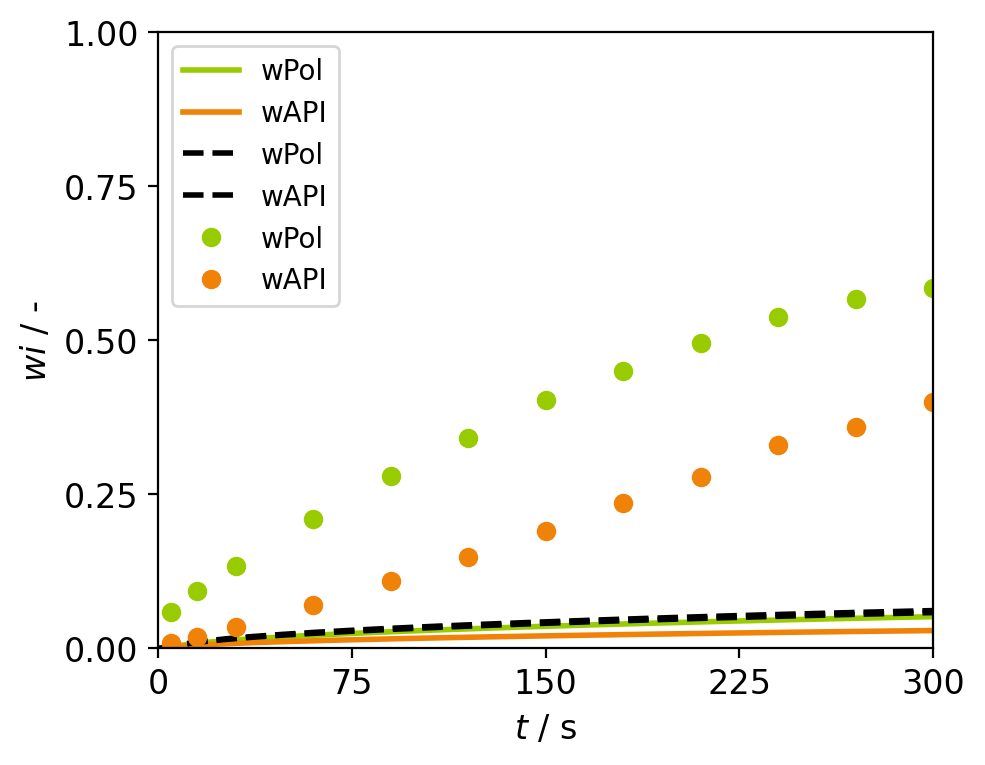

In [15]:

font = {'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

color1 = "#99CC00"
color2 = "#F08208"
color3 = "#99CDE9"

fig, ax = plt.subplots(figsize=(5, 4), dpi = 200)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# ax.plot(t/60,wtid[:,0], "--",color = color1 , 
#         linewidth = 2.0, label = "wPol")
# ax.plot(t/60,wtid[:,1], "--",color = color2 , 
#         linewidth = 2.0, label = "wAPI")

ax.plot(t/60,wt[:,1], "-",color = color1 , 
        linewidth = 2.0, label = "wPol")
ax.plot(t/60,wt[:,2], "-",color = color2 , 
        linewidth = 2.0, label = "wAPI")
ax.plot(t/60,wtid[:,1], "--",color = "k" , 
        linewidth = 2.0, label = "wPol")
ax.plot(t/60,wtid[:,2], "--",color = "k"  , 
        linewidth = 2.0, label = "wAPI")
ax.plot(texp,wexp[:,1], "ro",color = color1 , 
        linewidth = 2.0, label = "wPol")
ax.plot(texp,wexp[:,2], "go",color = color2 , 
        linewidth = 2.0, label = "wAPI")



ax.legend(fontsize="small")
ax.set_xlabel('$t$ / s')
ax.set_ylabel('$wi$ / -')
ax.axis([0, 300., 0., 1])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))
plt.show()



# ax2.plot(zexp2*Lt[0],tolu, "o")


[[0.01443001 0.01443001 0.01443001 0.01443001 0.01443001 0.01443001
  0.01443001 0.01443001 0.01443001 0.01443001 0.01443001 0.01443001
  0.01443001 0.01443001 0.01443001 0.01443001 0.01443001 0.01443001
  0.01443001 0.01443001 0.01443001]
 [0.01443001 0.01443001 0.01443001 0.01443001 0.01443001 0.01443001
  0.01443001 0.01443001 0.01443001 0.01443002 0.01443002 0.01443003
  0.01443005 0.01443007 0.01443002 0.01443043 0.01444029 0.01453398
  0.01517665 0.0189389  0.04135421]
 [0.01443001 0.01443001 0.01443001 0.01443001 0.01443002 0.01443002
  0.01443002 0.01443003 0.01443004 0.01443007 0.01443026 0.01443134
  0.01443665 0.01445908 0.01454269 0.01482156 0.01566344 0.01800257
  0.02416672 0.04022977 0.09671658]
 [0.01443005 0.01443006 0.01443008 0.01443011 0.01443015 0.01443025
  0.01443057 0.01443174 0.01443562 0.01444728 0.01447934 0.0145609
  0.01475428 0.01518461 0.01608968 0.01790555 0.02142459 0.02810451
  0.04070908 0.06612862 0.1380517 ]
 [0.01443026 0.01443046 0.01443105 0.0144

[[<matplotlib.lines.Line2D at 0x2751db57410>],

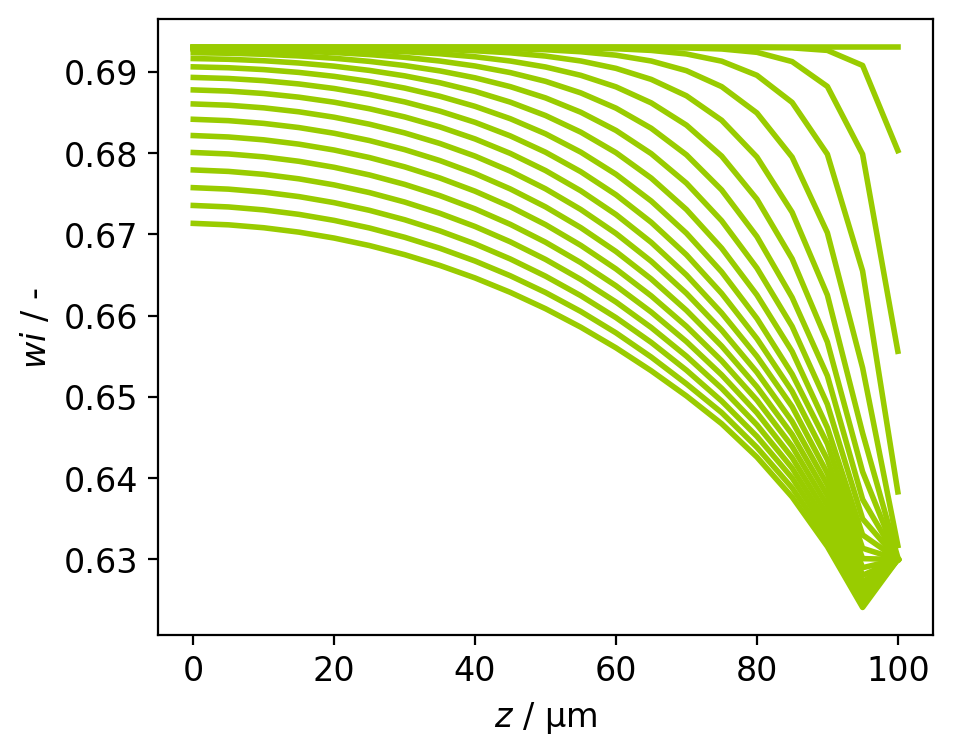

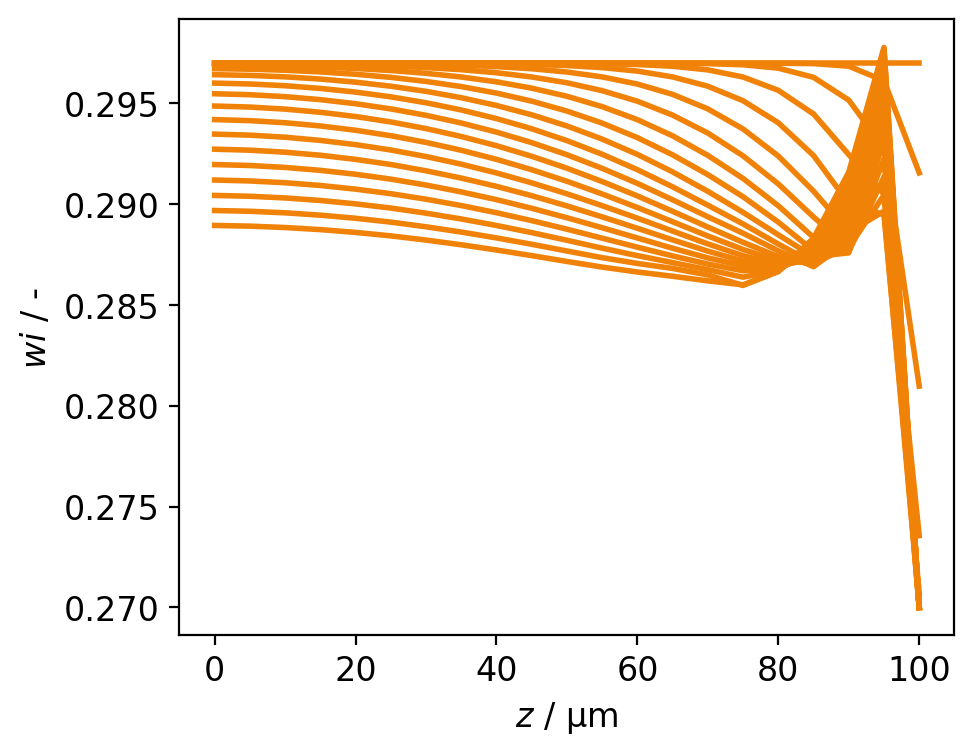

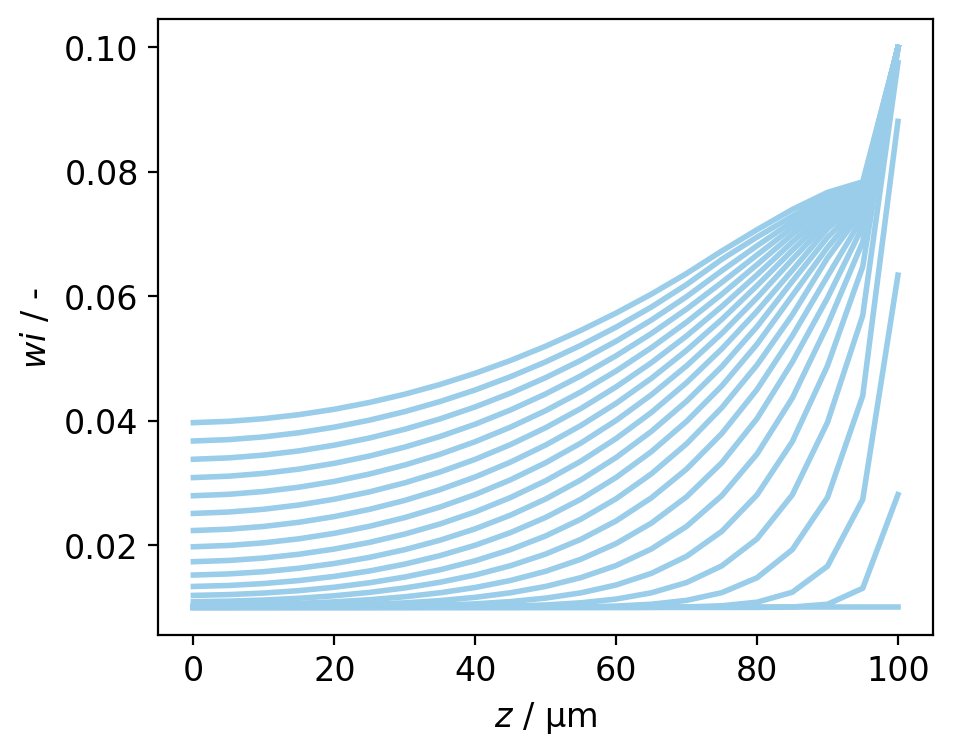

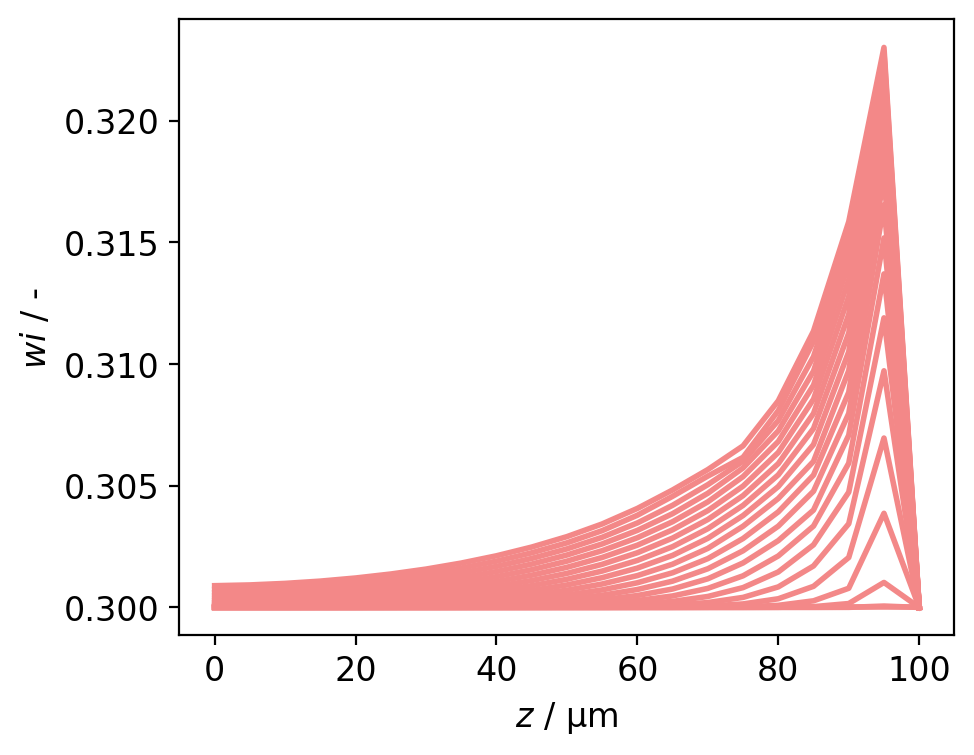

In [16]:
color1 = "#99CC00"
color2 = "#F08208"
color3 = "#99CDE9"
color4 = "#F38888"

fig1, ax1 = plt.subplots(figsize=(5, 4), dpi = 200)
fig2, ax2 = plt.subplots(figsize=(5, 4), dpi = 200)
fig3, ax3 = plt.subplots(figsize=(5, 4), dpi = 200)
fig4, ax4 = plt.subplots(figsize=(5, 4), dpi = 200)
fig1.subplots_adjust(hspace=0.5, wspace=0.3)
fig2.subplots_adjust(hspace=0.5, wspace=0.3)
fig3.subplots_adjust(hspace=0.5, wspace=0.3)
fig4.subplots_adjust(hspace=0.5, wspace=0.3)
ax1.set_xlabel('$z$ / µm')
ax1.set_ylabel('$wi$ / -')
ax2.set_xlabel('$z$ / µm')
ax2.set_ylabel('$wi$ / -')
ax3.set_xlabel('$z$ / µm')
ax3.set_ylabel('$wi$ / -')
ax4.set_xlabel('$z$ / µm')
ax4.set_ylabel('$wi$ / -')
[ax1.plot(zvec*1E6,wtz[i,1,:], "-",color = color1 , linewidth = 2.0) for i,val in enumerate(wtz[:,0,0])]
# ax1.plot(zexp1*Lt[0],meth, "o")
print(wtz[:,0,:]/wtz[:,1,:])
[ax2.plot(zvec*1E6,wtz[i,2,:], "-",color = color2 , linewidth = 2.0) for i,val in enumerate(wtz[:,0,0])]

[ax3.plot(zvec*1E6,wtz[i,0,:], "-",color = color3 , linewidth = 2.0) for i,val in enumerate(wtz[:,0,0])]\

[ax4.plot(zvec*1E6,wtz[i,2,:]/(wtz[i,1,:]+wtz[i,2,:]), "-",color = color4 , linewidth = 2.0) for i,val in enumerate(wtz[:,0,0])]\


# from diffusionpy import correctMB
# correctMB(dlnai_dlnwi,mobile,nt,wi0)